In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import v2

In [2]:
def visualize(image):
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.axis('off')
    plt.xlabel('ungsung')
    plt.show()

image_path = './ungsung_dataset/ungsung/ungsung1.jpeg'

sample = Image.open(image_path)
sample = ImageOps.exif_transpose(sample) 
t = v2.Resize(size=(2048, 1536))
sample = t(sample)
print(sample.size)

(1536, 2048)


In [5]:
transformer_train = v2.Compose(
    [
        v2.Resize(size=(128, 128)),
        v2.RandomHorizontalFlip(1),
        v2.RandomRotation(degrees=30),
        v2.ColorJitter(
            brightness=0.3,
            contrast = 0.3,
            saturation = 0.3,
            hue=0.1,
        ),
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
    ]
)
transformer_test = v2.Compose(
    [
        v2.Resize(size=(128, 128)),
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
    ]
)

In [7]:
data_path = './ungsung_dataset/'

total_dataset = datasets.ImageFolder(root=data_path, transform=None)

train_size = int(len(total_dataset) * 0.8)
test_size  = len(total_dataset) - train_size

train_subset, test_subset = random_split(total_dataset, [train_size, test_size])
total_dataset.class_to_idx, len(train_subset), len(test_subset)

({'not': 0, 'test': 1, 'ungsung': 2}, 1097, 275)

In [8]:
class UNGSUNGDATASET(Dataset):
    def __init__(self, subset, transformer):
        self.subset = subset
        self.transformer = transformer
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, index):
        img, label = self.subset[index]
        img = self.transformer(img)
        return img, label

train_dataset = UNGSUNGDATASET(train_subset, transformer_train)
test_dataset = UNGSUNGDATASET(test_subset, transformer_test)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, drop_last=True)        

In [2]:
class UNGSUNG(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 32, 5, 1, 2)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.linear0 = nn.Linear(32768, 64)
        self.linear1 = nn.Linear(64, 1)
    def forward(self, inputs):
        x = F.relu(self.conv1(inputs))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = F.relu(self.linear0(x))
        outputs = F.sigmoid(self.linear1(x))
        return outputs

# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# device = torch.device('cpu')
# model = UNGSUNG().to(device)
# device

In [10]:
loss_fn = nn.BCELoss()
optimizer = optim.AdamW(model.parameters())
epochs = 30

In [11]:
def evaluate_batch(dataloader, model, loss_fn):
    model.eval()
    losses = []
    correct, total = 0, 0
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device).to(torch.float32)
            preds = model(inputs).squeeze()
            loss = loss_fn(preds, labels)
            losses.append(loss.item())
            preds_label = (preds > 0.5)
            correct += (preds_label == labels).sum().item()
            total += len(labels)
    val_loss_avg = sum(losses) / len(losses)
    acc = correct / total 
    return val_loss_avg, acc

In [26]:
### Training code

# from time import time
# for epoch in range(epochs):
#     start_time = time()
#     model.train()
#     for train_batch in train_dataloader:
#         inputs = train_batch[0].to(device)
#         labels = train_batch[1].to(device).to(torch.float32)
#         preds = model(inputs).squeeze()
#         loss = loss_fn(preds, labels)
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#     loss_avg, acc = evaluate_batch(test_dataloader, model, loss_fn)
#     end_time = time()
#     print(f"\nloss / acc at epoch {epoch+1}/{epochs}: {loss_avg:.4f}/{acc:.4f} === spend {end_time-start_time:.4f}\n")


loss / acc at epoch 1/30: 0.3675/0.8603 === spend 68.6554


loss / acc at epoch 2/30: 0.5377/0.8199 === spend 70.6754


loss / acc at epoch 3/30: 0.3538/0.8860 === spend 77.0419


loss / acc at epoch 4/30: 0.3797/0.8713 === spend 78.3889


loss / acc at epoch 5/30: 0.2711/0.8824 === spend 77.3750


loss / acc at epoch 6/30: 0.2620/0.8824 === spend 79.9744


loss / acc at epoch 7/30: 0.3743/0.8824 === spend 80.4290


loss / acc at epoch 8/30: 0.3582/0.8897 === spend 80.3448


loss / acc at epoch 9/30: 0.2407/0.9007 === spend 79.8101


loss / acc at epoch 10/30: 0.3933/0.8897 === spend 79.1728


loss / acc at epoch 11/30: 0.3104/0.8897 === spend 77.8554


loss / acc at epoch 12/30: 0.2856/0.9228 === spend 78.4534


loss / acc at epoch 13/30: 0.5354/0.8860 === spend 78.3354


loss / acc at epoch 14/30: 0.3042/0.9081 === spend 78.6459


loss / acc at epoch 15/30: 0.5530/0.8640 === spend 84.8628


loss / acc at epoch 16/30: 0.3209/0.8897 === spend 81.4702


loss / acc at epoch 17/30: 0.361

In [12]:
# torch.save(model.state_dict(), './ungsung_classifier_model.pth')

In [3]:
param_loaded = torch.load('ungsung_classifier_model.pth', weights_only=True)
model = UNGSUNG()
model.load_state_dict(param_loaded)

NameError: name 'UNGSUNG' is not defined

RGB
0.473491907119751


/var/folders/f4/dlc6vs952d9_s55nyfp4qb8r0000gn/T/ipykernel_2704/2624160936.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


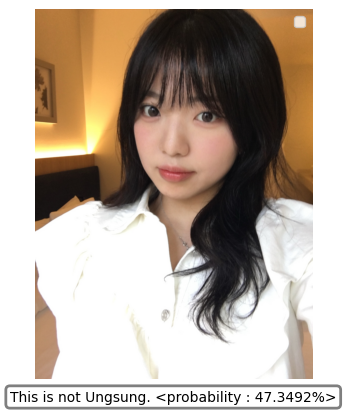

In [8]:
def visualize_test(image_path, prediction, pred):
    image = Image.open(image_path)
    image = ImageOps.exif_transpose(image)
    image = image.convert(mode='RGB')
    plt.imshow(image)
    plt.axis('off')
    plt.text(
        0.5, -0.03, f"{prediction} <probability : {pred*100:.4f}%>",
        fontsize=10, ha="center", va="top", transform=plt.gca().transAxes,
        bbox=dict(facecolor="white", alpha=0.5, boxstyle="round,pad=0.3", linewidth=2),
    )
    plt.legend()
    plt.show()
    
image_path = './ungsung_dataset/test/test_ungsung3.jpeg'
image = Image.open(image_path)
print(image.mode)
image = image.convert(mode='RGB')
image_tensor = transformer_test(image).unsqueeze(0)
result = model(image_tensor)
print(result[0].item())
if result[0].item() > 0.5:
    prediction = "This is Ungsung."
else:
    prediction = "This is not Ungsung."

visualize_test(image_path, prediction, result[0].item())